# Fitovanje radijalnih brzina koristeći PyMC i Exoplanet

Kroz ovaj notebook ćemo fitovati radijalne brzine zvezde K2-24, sa ciljem da otkrijemo parametre planeta K2-24b i K2-24c koje nju orbitiraju, na osnovu njihovog gravitacionog uticaja na zvezdu - koji će se pokazati kroz radijalnu brzinu zvezde. Za fitovanje radijalnih brzina ćemo koristiti paket `exoplanet` i njegov dependency `pymc`. 

In [ ]:
import exoplanet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Prikupljanje i obrada podataka

Za početak ćemo preuzeti podatke iz RadVel baze. Kod koji sledi čita ove podatke i čuva ih kao *pandas* dataframe:

In [4]:
url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

Ako pogledamo sadržaj dataframea koji smo dobili, videćemo da se u njemu nalaze vrednosti radijalne brzine i greške merenja iste za zvezdu K2-24, i to za 32 različita trenutka u vremenu.

In [5]:
data

,errvel,t,vel
0,1.593725,2364.819580,6.959066
1,1.600745,2364.825101,5.017650
2,1.658815,2364.830703,13.811799
3,1.653224,2366.827579,1.151030
4,1.639095,2367.852646,9.389273
5,1.723691,2373.888150,-2.820614
6,1.907690,2374.852412,-0.772991
7,1.709263,2376.863820,-2.222920
8,1.838565,2377.866073,0.146115
9,1.649715,2378.834011,2.739558


Sada ćemo ove podatke i plotovati:

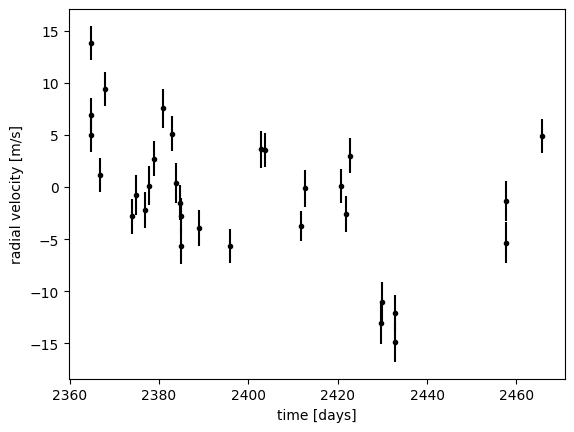

In [6]:
x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

Sada ćemo iskoristiti funkciju *exoplanet.estimate_semi_amplitude* kako bismo dobili aproksimaciju poluamplitude radijalne brzine. Ova vrednost nam ukazuje na to koliko drastično dve planete u sistemu K2-24 utiču na zvezdu oko koje orbitiraju, i biće nam bitan početni parametar za fitovanje modela. Na narednoj ilustraciji je ona označena sa K.

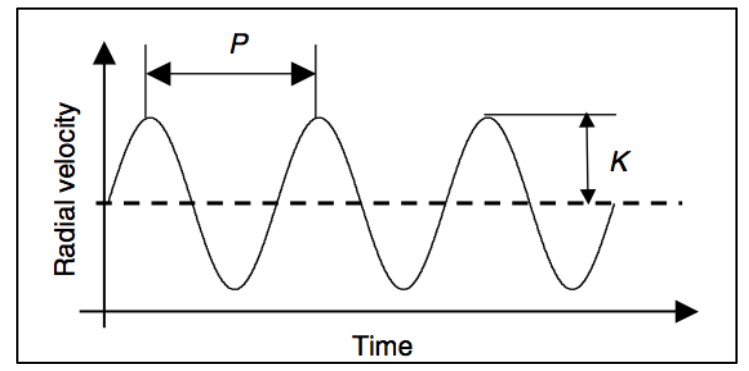

In [7]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## 2. Priprema modela

Sada ćemo uključiti i bliblioteku PyMC3. Ovo je biblioteka za probabilističko programiranje i bajesovsku statističku analizu koja koristi MCMC (Markov Chain Monte Carlo) tehniku kako bi nam pomogla u proceni parametara egzoplaneta.

Prvo ćemo definisati model. Koristićemo naredne očekivane vrednosti:

`t0`: vreme referentnog tranzita, modelovano normalnom raspodelom

`logP`: prirodni logaritam orbitalnog perioda P, modelovan normalnom raspodelom

`logK`: prirodni logaritam polu-amplitude K

`ecc`: ekscentricitet, modelovan uniformnom raspodelom između 0 i 1, jer nemamo apriorne pretpostavke o njoj, već samo granične vrednosti

`omega`: argument periastrona

Kreiraćemo i početnu exoplanet orbitu, kao i početni model radijalne brzine zasnovan na njoj:

In [ ]:
import pymc as pm
import pymc_ext as pmx
import pytensor.tensor as tt
from pymc.distributions.transforms import Interval

with pm.Model() as model:
    # Gausovi prajori
    t0 = pm.Normal("t0", mu=np.array(t0s), sigma=np.array(t0_errs), shape=2)
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sigma=np.array(period_errs) / np.array(periods),
        shape=2,
        initval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))

    # Prajor za poluamplitudu
    logK = pm.Normal(
        "logK", mu=np.log(Ks), sigma=2.0, shape=2, initval=np.log(Ks)
    )

    # Definišemo početne vrednosti (skoro kružne orbite)
    initval_x = 0.01 * np.ones(2)
    initval_y = 0.01 * np.ones(2)
    initval_tuple = (initval_x, initval_y)

    # Fitujemo ecs_x i ecs_y komponente za 2 planete
    ecs_x, ecs_y = pmx.unit_disk(
        "ecs_x",
        "ecs_y",
        shape=2,
        initval=initval_tuple
    )

    # Računamo 'ecc' i 'omega' kao nizove sa po dva elementa
    ecc = pm.Deterministic("ecc", ecs_x**2 + ecs_y**2)
    omega = pm.Deterministic("omega", tt.arctan2(ecs_y, ecs_x))

    # Jitter & RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sigma=5.0)
    trend = pm.Normal("trend", mu=0, sigma=10.0 ** -np.arange(3)[::-1], shape=3)

    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    def get_rv_model(t, name=""):
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    rv_model = get_rv_model(x)
    rv_model_pred = get_rv_model(t, name="_pred")

    err = tt.sqrt(yerr**2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sigma=err, observed=y)

Probaćemo da optimizujemo model i da dobijemo bolji fit koristeći PyMC. Pre nego što pokrenemo spori i zahtevni MCMC sampler, iskoristićemo Maximum A Posteriori (MAP) algoritam koji će izračunati argumente koji maksimizuju verovatnosnu raspodelu parametara koje smo u modelu definisali. Ovo će biti odličan početni korak za MCMC.

In [ ]:
with model:
    initvals = {
        trend: np.zeros(3),
        logK: np.log(Ks), 
        logP: np.log(periods),  
        t0: np.array(t0s) 
    }

    map_soln = pmx.optimize(start=initvals, vars=[trend])
    map_soln = pmx.optimize(start=map_soln, vars=[t0, trend, logK, logP, logs])
    map_soln = pmx.optimize(start=map_soln, vars=[ecs_x, ecs_y])
    map_soln = pmx.optimize(start=map_soln)

    print(map_soln)

Output()

Output()

Output()

Output()

{'t0': array([2072.79480006, 2082.62510004]), 'logP': array([3.03903599, 3.74628244]), 'logK': array([1.65260219, 1.58941837]), 'ecs_x_interval__': array([ 0.85094221, -0.79983955]), '__ecs_y_unit_disk_interval__': array([-0.62583534, -0.11130297]), 'logs': array(0.83079361), 'trend': array([ 1.17530939e-03, -3.74447859e-02, -2.24235875e+00]), 'ecs_x': array([ 0.40152951, -0.37988032]), '__ecs_y_unit_disk': array([-0.30308908, -0.0555941 ]), 'P': array([20.88510009, 42.36330066]), 'ecs_y': array([-0.27758295, -0.05142653]), 'ecc': array([0.23827824, 0.14695374]), 'omega': array([-0.60487257, -3.00703506]), 'vrad': array([[ 1.50231913,  4.12003704],
       [ 1.49497089,  4.12054165],
       [ 1.48751888,  4.12105169],
       [-0.87539862,  4.17847132],
       [-1.84767111,  4.11316176],
       [-4.07267681,  2.45266422],
       [-3.67081489,  1.98663152],
       [-1.59492073,  0.84398959],
       [ 0.2188788 ,  0.19509865],
       [ 2.37220569, -0.47432902],
       [ 6.04244141, -2.0211

Plotovaćemo optimizovani MAP model:

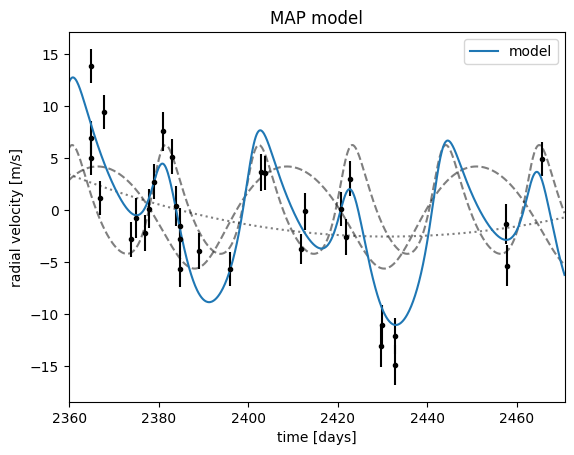

In [12]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

Sada vidimo da naš model relativno dobro pogađa error barove empirijskih podataka! 

## 3. MCMC optimizacija modela

Nakon što je naš model dobio oblik, vreme je da počnemo sa MCMC semplovanjem. Naredni kod pokreće MCMC semplovanje kojim se istražuje prostor mogućih parametara. U pitanju je biased random walk, koji će izvući hiljadu potencijalnih parametara, ali će težiti ka verovatnijim vrednostima. Ovim putem ćemo dobiti aproksimativnu statističku raspodelu parametara modela.

In [18]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, logP, logK, ecs_x, __ecs_y_unit_disk, logs, trend]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## 4. Analiza rezultata

Ovde počinjemo sa analizom rezultata! Naš prvi korak je generisanje corner plota distribucije parametara. Na dijagonali možemo videti distribucije specifičnih parametara, a na ostalim plotovima možemo videti kako su korelisani određeni parovi parametara.

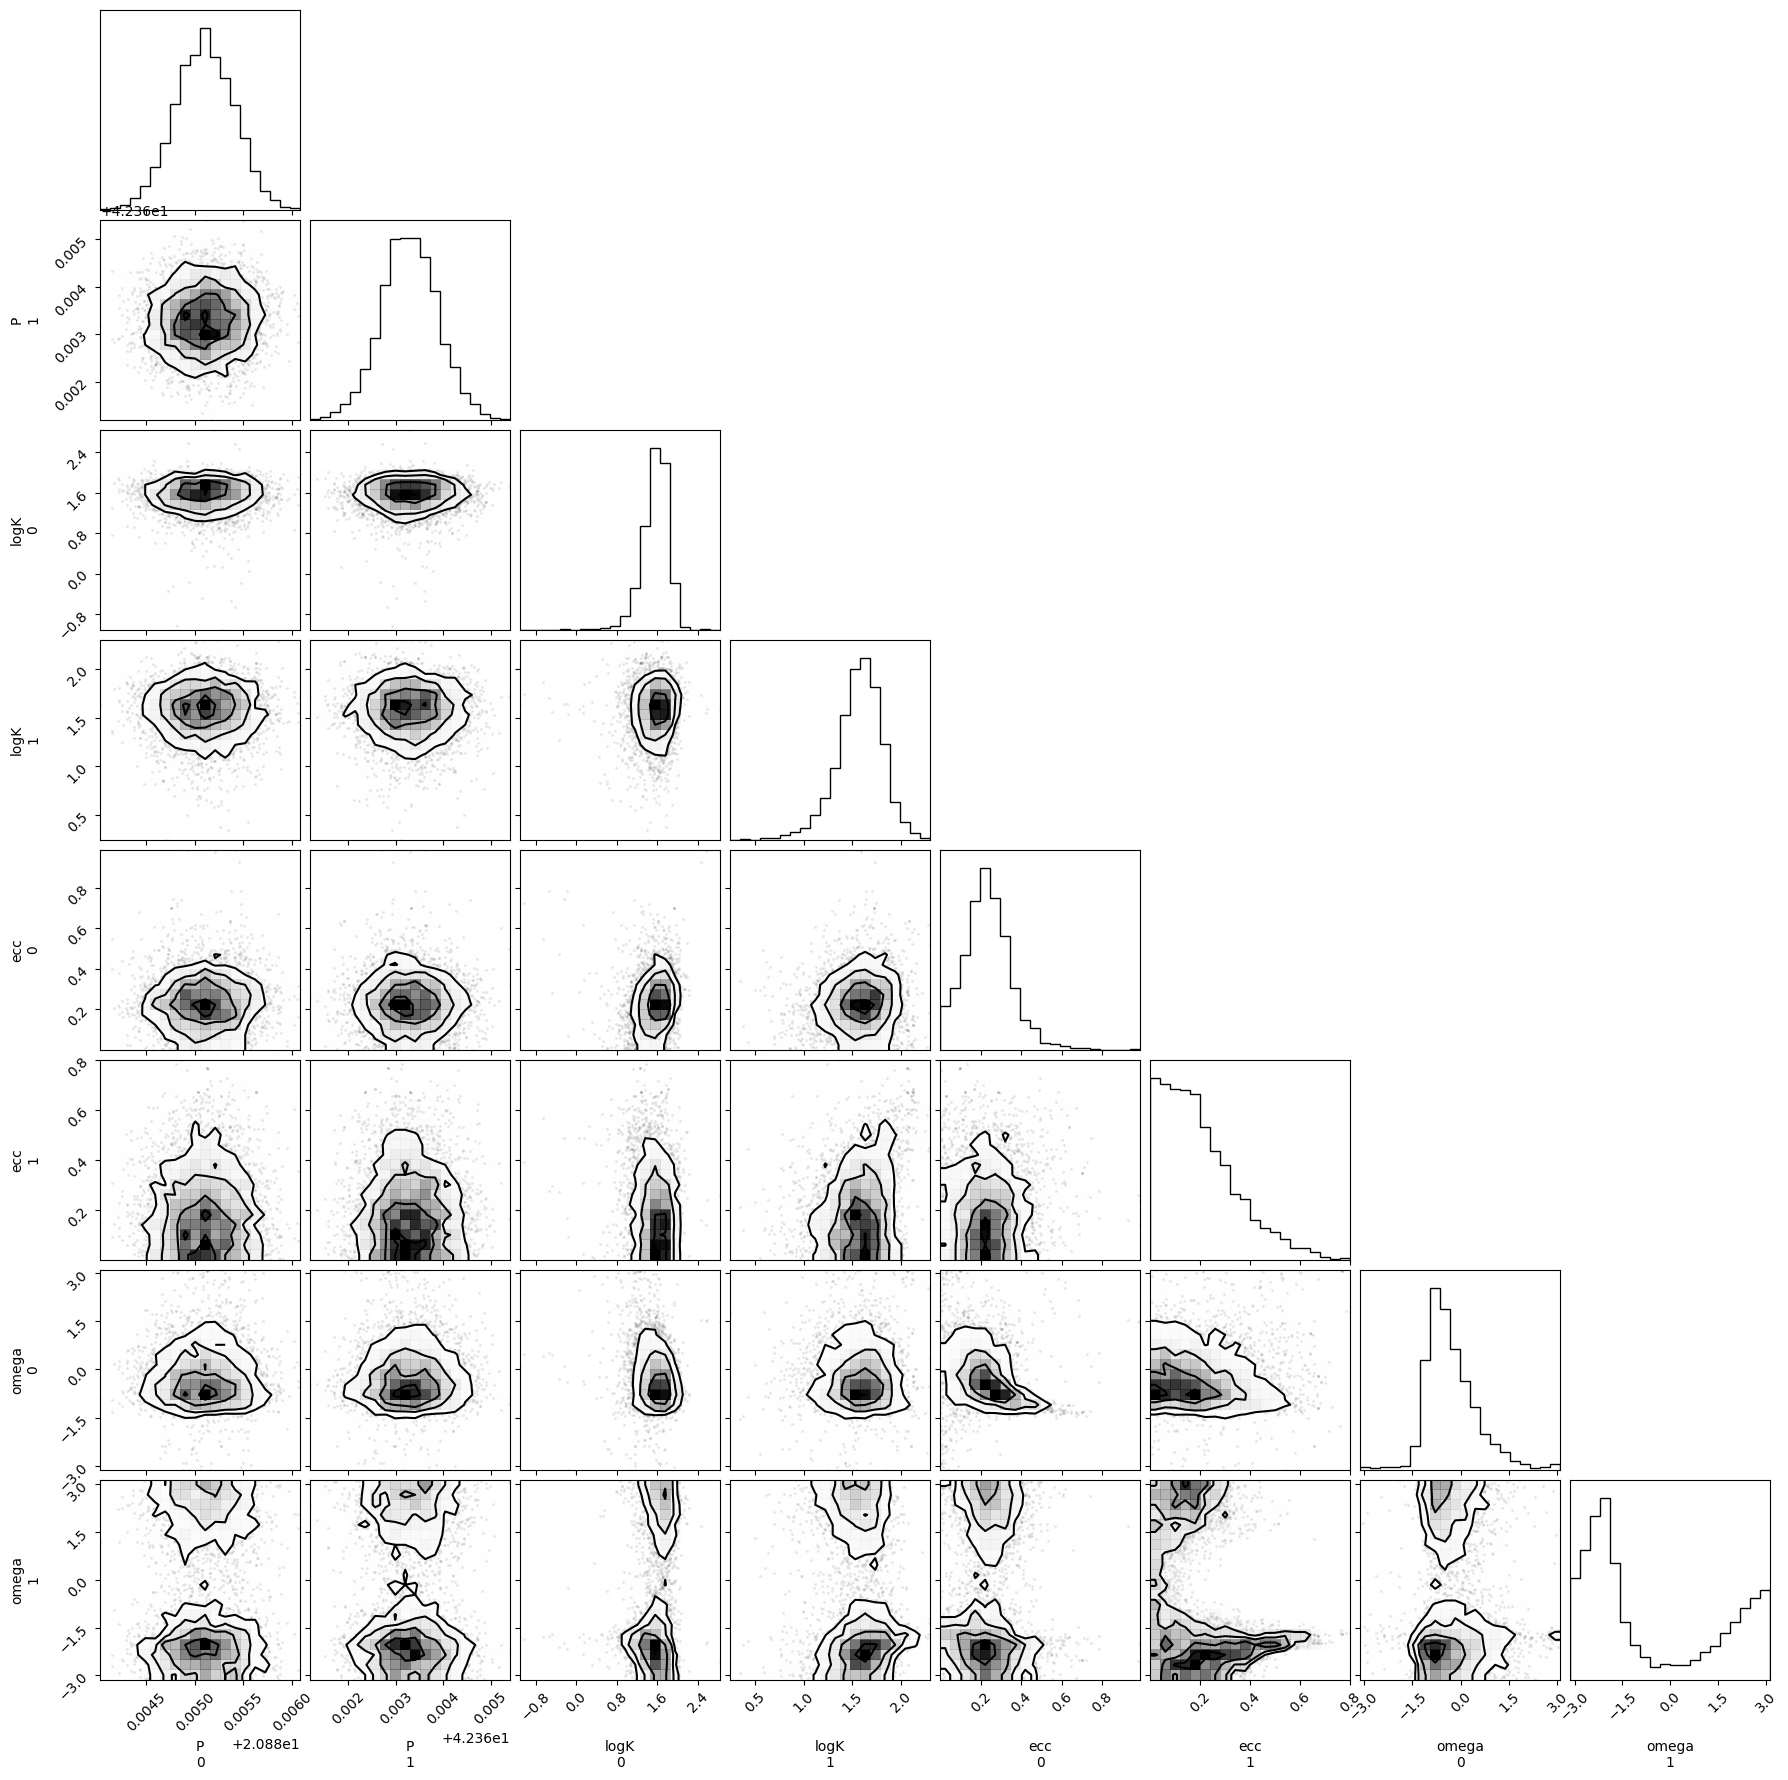

In [19]:
import corner

with model:
    _ = corner.corner(trace, var_names=["P", "logK", "ecc", "omega"])

Ostaje nam još i da plotujemo radijalnu brzinu koju model predviđa. Šejdovaćemo prostor između percentila 16 i 84, a plava linija će predstavljati medijanu, odnosno pedeseti percentil predviđanja modela. Plotovaćemo i vrednosti iz posmatranja kao tačke sa error barovima, ko i ranije.

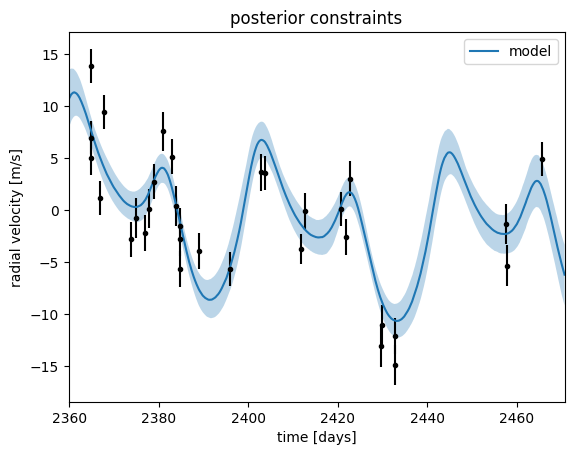

In [ ]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

Na samom kraju ćemo plotovati i koliko svaka od dve planete doprinose radijalnoj brzini matične zvezde.

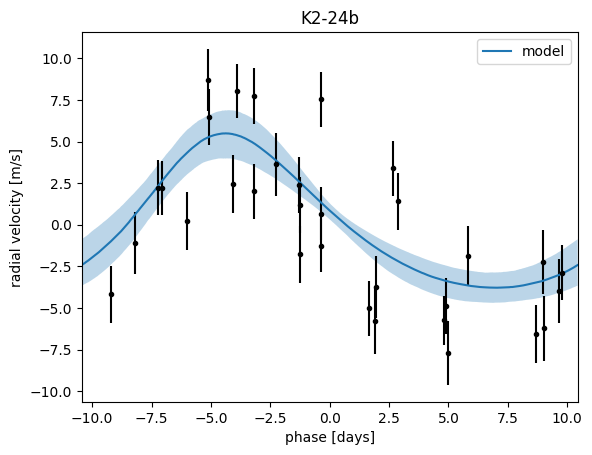

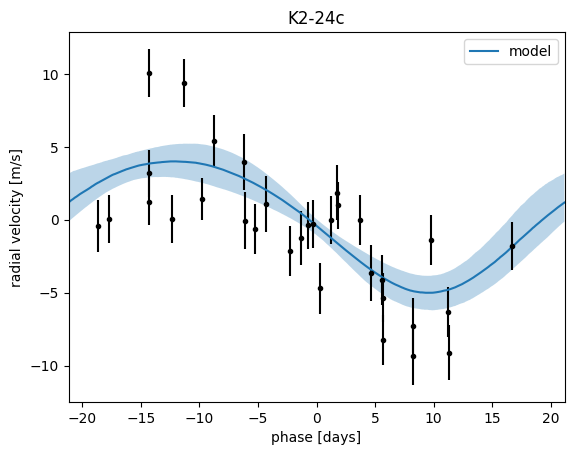

In [ ]:
for n, letter in enumerate("bc"):
    plt.figure()

    p = np.median(trace.posterior["P"].values[:, :, n])
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    other = np.median(
        trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
    )
    other += np.median(trace.posterior["bkg"].values, axis=(0, 1))

    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        trace.posterior["vrad_pred"].values[:, :, inds, n],
        [16, 50, 84],
        axis=(0, 1),
    )
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

Za kraj nam ostaje još i da izračunamo masu svake od planeta u Zemljinim masama. Uzećemo parametre koje smo dobili kroz MCMC samplovanje i za koje verujemo da dobro odgovaraju samim planetama. Koristićemo jednačinu 12.15 iz knjige Astrobiology by Longstaff. Ovom metodom dobijamo minimalnu moguću masu planete.

In [ ]:
import arviz as az
import astropy.units as u
import astropy.constants as const

posterior = az.extract(trace)

logK_med = np.median(posterior["logK"].values, axis=0)
K_med = np.exp(logK_med) * u.m / u.s

P_med = np.median(posterior["P"].values, axis=0) * u.day

ecc_med = np.median(posterior["ecc"].values, axis=0)

# Masa zvezde K2-24 je oko 1.07 mase Sunca
M_star = 1.07 * u.M_sun

# Masa planete je (Mp * sin(i))
# K = (2*pi*G / P)^(1/3) * (Mp*sin(i) / M_star^(2/3)) * (1 / sqrt(1-e^2))

# U kilogramima
Mp_sin_i_kg = K_med * (1 - ecc_med**2)**0.5 * (M_star**2 * P_med / (2 * np.pi * const.G))**(1/3)

# U zemljinim masama
Mp_sin_i_earth = Mp_sin_i_kg.to(u.M_earth)

print("\n--- Izračunate mase planeta ---")
print(f"Planeta b: {Mp_sin_i_earth[0]:.2f}")
print(f"Planeta c: {Mp_sin_i_earth[1]:.2f}")


--- Izračunate mase planeta ---
Planeta b: 29.49 earthMass
Planeta c: 27.28 earthMass
